## SETUP

In [1]:
# MUST be first cell: set multiprocessing method for Windows
import torch.multiprocessing as mp
try:
    mp.set_start_method("spawn", force=True)
except RuntimeError:
    pass  # Already set

In [2]:
import os
import sys
from pathlib import Path

# FOR LOCAL USE THIS LINES
current = Path.cwd()
src_path = current / "src" if (current / "src").exists() else current.parent

# FOR COLAB USE THIS LINE INSTEAD
# BRANCH_NAME = "main"  # Change this to switch branches
# !git clone -b {BRANCH_NAME} https://github.com/MatteoCamillo-code/GeoLoc-CVCS.git
# !cd /content/GeoLoc-CVCS && git pull origin {BRANCH_NAME} && cd ..
# src_path = Path("/content/GeoLoc-CVCS/src").resolve()

sys.path.insert(0, str(src_path))

from utils.paths import find_project_root

# Set working directory and sys.path properly
project_root = find_project_root(src_path)
data_dir = project_root / "data"
history_dir = project_root / "outputs" / "history"
checkpoint_dir = project_root / "outputs" / "checkpoints"
os.chdir(project_root)
sys.path.insert(0, str(project_root / "src"))
print("CWD:", Path.cwd())

CWD: F:\InfTech\Prodotti\Python\GeoLocGit\GeoLoc-CVCS


In [3]:
import pandas as pd
import torch

from configs.baseline_multi_head_ISN import TrainConfig

cfg = TrainConfig()

from src.map_partitioning.s2.plotting import visualize_gps_predictions

from utils.seed import seed_everything
import utils.model_loader_utils as utils


c:\Users\camil\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
cfg = TrainConfig()
seed_everything(cfg.seed)

device = cfg.device if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cuda


## DATA LOADER

In [5]:
import kagglehub

path = kagglehub.dataset_download("josht000/osv-mini-129k")
path = path + "/osv5m"
print("Path to dataset files:", path)

image_root = path + "/train_images"

Path to dataset files: C:\Users\camil\.cache\kagglehub\datasets\josht000\osv-mini-129k\versions\1/osv5m


In [6]:
if len(cfg.scenes) == 1 and cfg.scenes[0] == "total":
    train_val_path = data_dir / "metadata/s2-geo-cells/train_val_split_geocells_total.csv"
else:
    train_val_path = data_dir / "metadata/s2-geo-cells/train_val_split_geocells.csv"
cell_centers_dfs = {}
cells_hierarchy_dfs = {}

for scene in cfg.scenes:
    if cfg.same_partitions:
        cell_centers_path = data_dir / f"metadata/s2-geo-cells/cell_center_dataset_total.csv"
        cells_hierarchy_path = data_dir / f"metadata/s2-geo-cells/cell_hierarchy_dataset_total.csv"
    else:
        cell_centers_path = data_dir / f"metadata/s2-geo-cells/cell_center_dataset_{scene}.csv"
        cells_hierarchy_path = data_dir / f"metadata/s2-geo-cells/cell_hierarchy_dataset_{scene}.csv"
    
    cell_centers_df = pd.read_csv(cell_centers_path)
    cells_hierarchy_df = pd.read_csv(cells_hierarchy_path)
    
    # remove duplicates with same cell_id
    cell_centers_df = cell_centers_df.drop_duplicates(subset='cell_id_token')

    # Set S2 cell ID as index (assumes first column or 'cell_id' column)
    if 'cell_id_token' in cell_centers_df.columns:
        cell_centers_df = cell_centers_df.set_index('cell_id_token')
    else:
        # Set first column as index if it contains cell IDs
        cell_centers_df = cell_centers_df.set_index(cell_centers_df.columns[0])
        
    cell_centers_dfs[scene] = cell_centers_df
    cells_hierarchy_dfs[scene] = cells_hierarchy_df

In [7]:
from dataset.dataloader_utils import create_dataloaders

IMG_SIZE = 224

# Create all dataloaders with a single function call
loader_dict = create_dataloaders(
    image_root=image_root,
    csv_path=train_val_path,
    batch_size=cfg.batch_size,
    num_workers=cfg.num_workers,
    img_size=IMG_SIZE,
    seed=cfg.seed,
    train_subset_pct=cfg.train_size_pct,
    val_subset_pct=cfg.val_size_pct,
    scenes=cfg.scenes,
    augment=True,
    prefetch_factor=4,
    persistent_workers=True if cfg.num_workers > 0 else False,
    coarse_label_idx=cfg.coarse_label_idx,
    shuffle_val=True,
)

##  LOAD MODEL 

In [8]:
# Load all models
models = utils.load_models_from_consolidated_checkpoint(checkpoint_dir, cfg, loader_dict, device)

Searching for files with pattern: ^MH_ISN_res_wd_sp_v(\d+).pt$
Loading consolidated checkpoint: F:\InfTech\Prodotti\Python\GeoLocGit\GeoLoc-CVCS\outputs\checkpoints\MH_ISN_res_wd_sp_v1.pt

--- Loading model for scene: urban ---
Loaded epoch: 14

--- Loading model for scene: natural ---
Loaded epoch: 14

Successfully loaded 2 models for scenes: ['urban', 'natural']


In [9]:
from src.training.losses import CrossEntropyWithLabelSmoothing
criterion = CrossEntropyWithLabelSmoothing(ignore_index=-1, smoothing=cfg.label_smoothing)

In [10]:
# Get 10 samples from validation set for each scene
n_samples = 100
val_samples = utils.get_val_samples(loader_dict, cfg.scenes, n_samples=n_samples)

print(f"\nTotal scenes: {len(val_samples)}")
for scene, samples in val_samples.items():
    print(f"  {scene}: {len(samples)} samples")



Total scenes: 2
  urban: 100 samples
  natural: 100 samples



Scene: urban
Number of samples: 100
First sample details:
  Image shape: torch.Size([3, 224, 224])
  Image dtype: torch.float32
  Labels shape: torch.Size([3])
  Labels: [90, 50, 20]
  GPS shape: torch.Size([2])
  GPS (lat, lon): [34.75757598876953, -96.65318298339844]
Scene: natural
Number of samples: 100
First sample details:
  Image shape: torch.Size([3, 224, 224])
  Image dtype: torch.float32
  Labels shape: torch.Size([3])
  Labels: [1632, 893, 470]
  GPS shape: torch.Size([2])
  GPS (lat, lon): [48.353145599365234, -116.54756927490234]
============================================================Displaying first image from each scene:


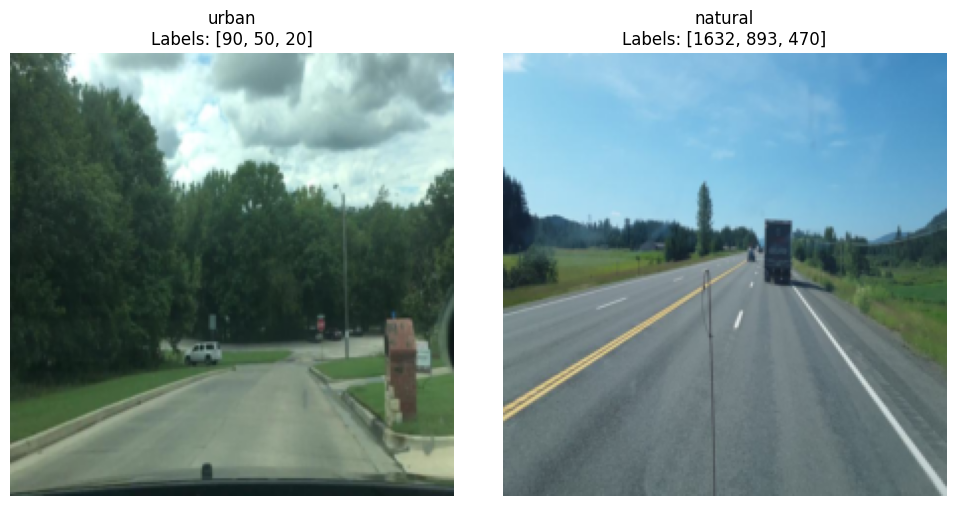

In [11]:
plot, prints = utils.print_samples(val_samples)

print(prints)
# Show the plot
plot.show()

In [12]:
# Run predictions with GPS coordinate prediction
predictions = utils.predict_samples(
    models, 
    val_samples, 
    loader_dict, 
    cell_centers_dfs, 
    cells_hierarchy_dfs, 
    cfg, 
    device,
    gps_method="weighted",  # or "argmax"
    top_k=1
)

# Print detailed results for each scene
for scene, scene_preds in predictions.items():
    print(f"\n{'='*60}")
    print(f"Scene: {scene}")
    print(f"{'='*60}")
    
    for pred in scene_preds:
        print(f"\nSample {pred['sample_idx']+1}:")
        print(f"  True GPS: {pred['true_gps']}")
        print(f"  Predicted GPS: {pred['predicted_gps']}")
        print(f"  Distance error: {pred['distance_km']:.2f} km")
        print(f"  True labels: {pred['true_label_names']}")
        print(f"  Predicted: {pred['predicted_label_names']}")
        print(f"  Confidence: {[f'{c:.2%}' for c in pred['confidences']]}")
        print(f"  Label match: {pred['true_labels'] == pred['predicted_labels']}")
    
    print(f"\nProcessed {len(scene_preds)} samples for {scene}")

# Print summary
print(f"\n{'='*60}")
print(f"Prediction Summary")
print(f"{'='*60}")
for scene, preds in predictions.items():
    correct_labels = sum(1 for p in preds if p['true_labels'] == p['predicted_labels'])
    avg_distance = sum(p['distance_km'] for p in preds) / len(preds)
    median_distance = sorted([p['distance_km'] for p in preds])[len(preds)//2]
    
    print(f"\n{scene}:")
    print(f"  Label accuracy: {correct_labels}/{len(preds)} correct ({correct_labels/len(preds)*100:.1f}%)")
    print(f"  Average GPS error: {avg_distance:.2f} km")
    print(f"  Median GPS error: {median_distance:.2f} km")



Scene: urban

Sample 1:
  True GPS: [34.75757598876953, -96.65318298339844]
  Predicted GPS: [32.96006774902344, -96.72953033447266]
  Distance error: 200.00 km
  True labels: ['87b369', '87b36c', '87b34']
  Predicted: ['864e9fc', '87938b4', '87938d']
  Confidence: ['2.38%', '3.39%', '6.95%']
  Label match: False

Sample 2:
  True GPS: [37.68202209472656, -95.46961975097656]
  Predicted GPS: [45.4719352722168, -122.61980438232422]
  Distance error: 2404.53 km
  True labels: ['87b85', '87b84', '87b9']
  Predicted: ['8640c24', '87bdd4', '87bf6c']
  Confidence: ['2.35%', '3.65%', '7.06%']
  Label match: False

Sample 3:
  True GPS: [41.57658767700195, -109.26290893554688]
  Predicted GPS: [39.526763916015625, -119.77533721923828]
  Distance error: 916.30 km
  True labels: ['875c', '875c', '875']
  Predicted: ['875c', '875c', '875']
  Confidence: ['32.71%', '26.00%', '17.05%']
  Label match: True

Sample 4:
  True GPS: [36.00064468383789, -115.10304260253906]
  Predicted GPS: [36.07395935

Loading USA map for visualization...


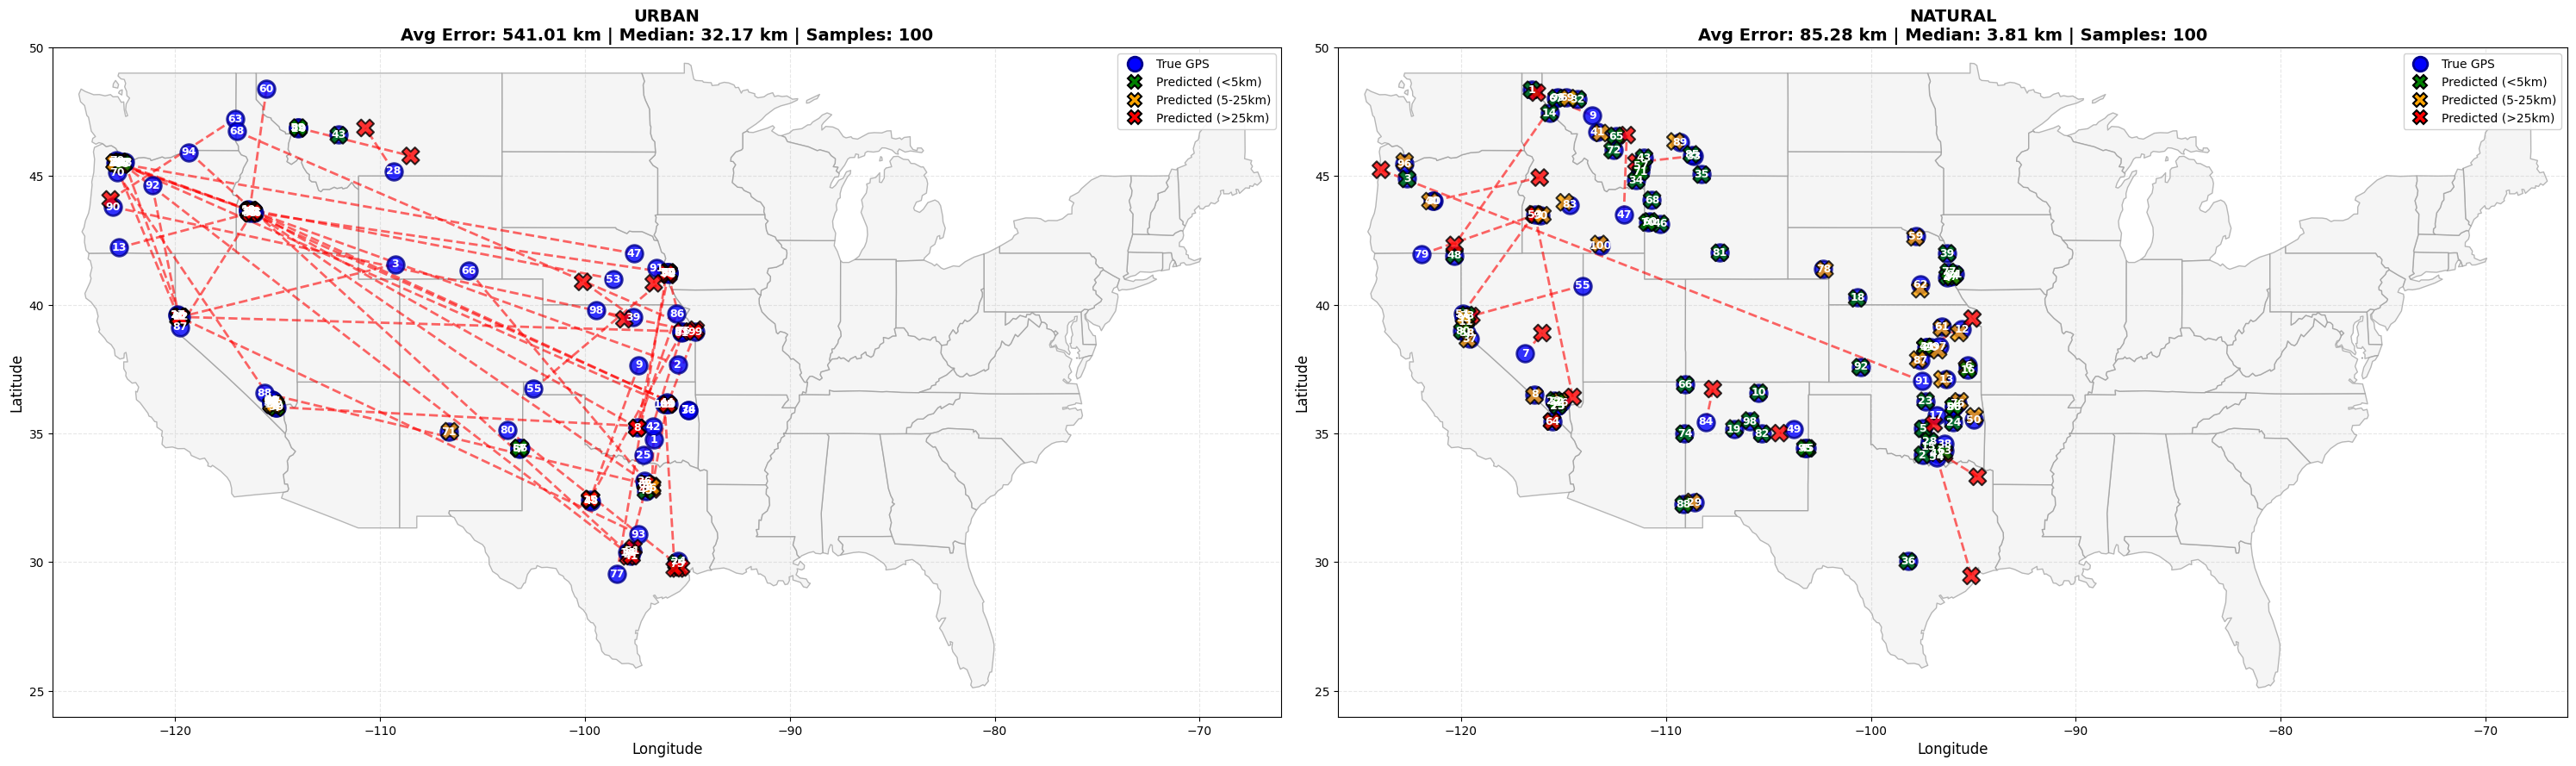


GPS PREDICTION ACCURACY STATISTICS

URBAN:
  Samples: 100
  Min error: 0.14 km
  Max error: 2750.87 km
  Mean error: 541.01 km
  Std error: 775.43 km
  Median error: 32.17 km

NATURAL:
  Samples: 100
  Min error: 0.04 km
  Max error: 2379.83 km
  Mean error: 85.28 km
  Std error: 277.93 km
  Median error: 3.81 km


In [13]:

# Visualize and get statistics
stats = visualize_gps_predictions(predictions)

# Print detailed statistics
print("\n" + "="*80)
print("GPS PREDICTION ACCURACY STATISTICS")
print("="*80)

for scene, scene_stats in stats.items():
    print(f"\n{scene.upper()}:")
    print(f"  Samples: {scene_stats['total']}")
    print(f"  Min error: {scene_stats['min']:.2f} km")
    print(f"  Max error: {scene_stats['max']:.2f} km")
    print(f"  Mean error: {scene_stats['mean']:.2f} km")
    print(f"  Std error: {scene_stats['std']:.2f} km")
    print(f"  Median error: {scene_stats['median']:.2f} km")
